## Import Modules

Scipy provides the *least_squares* optimization function

In [26]:
# Pandas and table
import pandas as pd
# Opimization
from scipy.optimize import least_squares
import numpy as np
# Plotting curve
import matplotlib.pylab as plt

## Definition of the model function used to fit the data
In the following example we will fit experimantal data with the ***Ogden model***

$\sigma_{\text{eng uniax}} = \displaystyle\sum_{p=1}^n 2\mu_{p} \left[\lambda^{(\alpha_{p}-1)} - \lambda^{-(1/2\alpha_{p}+1)}\right]$

For a 3rd order model, we have 6 parameters : $\mu_{1}, \alpha_{1}, \mu_{2}, \alpha_{2}, \mu_{3}, \alpha_{3}$

In [27]:
def OgdenModel(trueStrain, parameters, order):
    """Ogden hyperelastic model (incompressible material under uniaxial tension)
    Uses true strain and true stress data"""
                
    # parameter is a 1D array : [mu0,mu1,...,mun,alpha0,alpha1,...,alphan] 
    muVec = parameters.reshape(2, order)[0]
    alphaVec = parameters.reshape(2, order)[1]
    lambd = np.exp(trueStrain)
    # broadcasting method to speed up computation
    lambd = lambd[np.newaxis, :]
    muVec = muVec[:order, np.newaxis]
    alphaVec = alphaVec[:order, np.newaxis]
        
    trueStress = np.sum(2*muVec*(lambd**(alphaVec - 1) - lambd**(-((1/2)*alphaVec + 1))), axis=0)
    return trueStress

## Definition of the cost function

The aim of the optimisation algorithm is to minimize the Residual Sum of Squares

$\textit{Residual Sum of Squares} = \displaystyle\sum_{i=1}^n \left(\sigma_{model} - \sigma_{data}\right)^{2}$

In [28]:
# cost function to calculate the residuals. The fitting function holds the parameter values.  
def objectiveFun_Callback(parameters, exp_strain, exp_stress):  
    theo_stress = OgdenModel(exp_strain, parameters, order)   
    residuals = theo_stress - exp_stress 
    return residuals

## Read Experimental data

In [29]:
file = 'DragonSkin20.csv' # Replace space by %20 for html url 
header = pd.read_csv(file, delimiter = ';', usecols = ["PARAMETER", "INFO", "URL"]).head(15)
data = pd.read_csv(file, delimiter = ';',skiprows=18, names = ['Time (s)','True Strain','True Stress (MPa)','Engineering Strain','Engineering Stress (MPa)']) # the column headers are on line 16 from the top of the file

In [30]:
header

,PARAMETER,INFO,URL
0,Specimen Thickness (mm),3,NaN
1,Specimen Width (mm),6,NaN
2,Specimen Length (mm),33,NaN
3,Specimen Cross-section (cm^2),0.18,NaN
4,Standard,ASTM D412,NaN
5,Type of test,Pull-to-failure,NaN
6,Speed (mm/min),450,NaN
7,Machine,Instron 5569,NaN
8,Load Cell,1 kN - Instron 2525-806,NaN
9,Grippers,Instron 2710-010,NaN


In [31]:
data

,Time (s),True Strain,True Stress (MPa),Engineering Strain,Engineering Stress (MPa)
0,0.2,0.043637,0.009762,0.044600,0.009343
1,0.3,0.065743,0.019337,0.067950,0.018107
2,0.4,0.086950,0.028433,0.090843,0.026063
3,0.5,0.107613,0.036371,0.113620,0.032660
4,0.6,0.127830,0.044294,0.136360,0.038980
...,...,...,...,...,...
399,40.1,2.313885,44.406199,9.113635,4.390725
400,40.2,2.316130,44.617326,9.136365,4.401710
401,40.3,2.318370,44.835612,9.159090,4.413350
402,40.4,2.320600,45.047888,9.181820,4.424345


In [32]:
exp_strain = data['True Strain'].values        # .values converts panda series to numy array
exp_stress = data['True Stress (MPa)'].values

## Least square optimisation function

In [33]:
order = 3
initialGuessMu = np.array([0.1]*order)     # ["µ1","µ2","µ3"]
initialGuessAlpha = np.array([0.2]*order)  # ["α1","α2","α3"]
initialGuessParam = np.append(initialGuessMu,initialGuessAlpha)
nbparam = order*2
param_names = ["µ1","µ2","µ3","α1","α2","α3"]

In [34]:
# The least_squares package calls the Levenberg-Marquandt algorithm.
# best-fit paramters are kept within optim_result.x
optim_result = least_squares(objectiveFun_Callback, initialGuessParam, method ='lm', args=(exp_strain, exp_stress))
optim_parameters = optim_result.x
   
theo_stress = OgdenModel(exp_strain, optim_parameters, order)

## Results

In [35]:
print('optimised parameters:')
print('µ1=' + str(optim_parameters[0]))
print('µ2=' + str(optim_parameters[1]))
print('µ3=' + str(optim_parameters[2]))
print('α1=' + str(optim_parameters[3]))
print('α2=' + str(optim_parameters[4]))
print('α3=' + str(optim_parameters[5]))

optimised parameters:
µ1=0.007410965928874807
µ2=0.08212784341342322
µ3=0.011386289820264345
α1=3.336147096585031
α2=3.336174331775407
α3=3.336183246693289


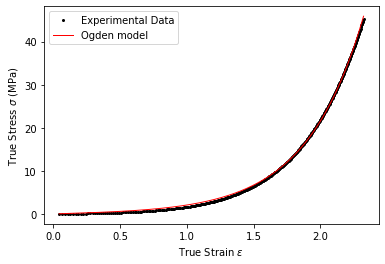

In [36]:
# Plotting the data
plt.plot(exp_strain,exp_stress,'k', marker="o", markersize=2, linestyle = 'None')
plt.plot(exp_strain,theo_stress,'r', linewidth=1)
#plt.title('Least-squares fit to data')
plt.xlabel('True Strain ' + r'$ \epsilon$')
plt.ylabel('True Stress ' +  r'$ \sigma$' + ' (MPa)')
plt.legend(['Experimental Data', 'Ogden model'],loc=2)
plt.grid(visible=None, which='both', axis='both')

In [37]:
# Define the strain value you want to evaluate
desired_strain = np.array([1.0])

# Compute the true stress using the Ogden model for strain=1.0
desired_stress = OgdenModel(desired_strain, optim_parameters, order)

print(desired_stress[0])

2.0734460377039805


Text(0, 0.5, '$\\Delta P_{open}$ [Pa]')

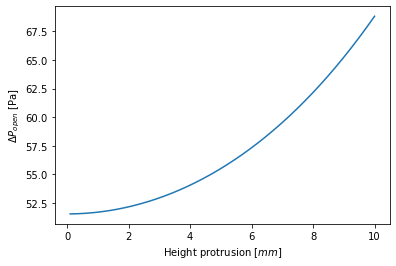

In [44]:
ID = 4e-3 # mm
t = 2e-3# mm
D=30e-3 #mm
t_membrane=1e-3
A_membrane = D*t_membrane

l0 = D 
h = np.linspace(0.1,10,40)*1e-3
l1= np.array(2*np.sqrt((D-(ID+2*t)/2)**2+h**2)+ID+2*t)
stress_membrane = OgdenModel(l1/l0, optim_parameters, order) #Mpa [N/mm2]
stress_membrane
F_membrane=stress_membrane*A_membrane #N
A_inlet = np.pi/4*ID**2 #M 
P_open = F_membrane/A_inlet 
plt.plot(h*1000,P_open)
plt.xlabel('Height protrusion [$mm$]')
plt.ylabel('$\\Delta P_{open}$ [Pa]')

In [39]:
l1

array([0.06000038, 0.06000482, 0.0600142 , 0.06002854, 0.06004783,
       0.06007206, 0.06010122, 0.06013532, 0.06017433, 0.06021825,
       0.06026706, 0.06032076, 0.06037932, 0.06044273, 0.06051097,
       0.06058403, 0.06066188, 0.0607445 , 0.06083187, 0.06092397,
       0.06102077, 0.06112225, 0.06122837, 0.06133912, 0.06145445,
       0.06157436, 0.06169879, 0.06182772, 0.06196113, 0.06209897,
       0.06224121, 0.06238782, 0.06253876, 0.06269399, 0.06285349,
       0.06301721, 0.06318511, 0.06335716, 0.06353332, 0.06371355])